# Introduction

In this notebook we demonstrate the use of **LDA (Latent Dirichlet Allocation)** generative statistical model for Information Retrieval technique to make trace link recovery between Test Cases and Bug Reports.

We model our study as follows:

* Each bug report title, summary and description compose a single query.
* We use each test case content as an entire document that must be returned to the query made

# Import Libraries

In [1]:
from mod_finder_util import mod_finder_util
mod_finder_util.add_modules_origin_search_path()

import pandas as pd
import pprint

from modules.models_runner.feat_br_models_runner import Feat_BR_Models_Runner
from modules.utils import aux_functions
from modules.utils import model_evaluator as m_eval
from modules.utils import firefox_dataset_p2 as fd
from modules.utils import similarity_measures as sm

from matplotlib import pyplot as plt

import warnings; warnings.simplefilter('ignore')

# Load Datasets

In [2]:
bugreports = fd.Datasets.read_selected_bugreports_df()
features = fd.Datasets.read_features_df()
br_2_features_matrix_final = fd.Feat_BR_Oracles.read_br_2_features_matrix_final_df()

SelectedBugReports.shape: (91, 18)
Features.shape: (21, 8)
BR_2_Features Matrix Final.shape: (91, 4)


# Running LDA Model - Exp-Vol UNION Oracle

In [3]:
models_runner_1 = Feat_BR_Models_Runner()

lda_model_1 = models_runner_1.run_lda_model()

evaluator_1 = m_eval.ModelEvaluator(oracle=fd.Feat_BR_Oracles.read_feat_br_expert_volunteers_union_df().T)

sim_thresh = 0.0

lda_eval_t1 = evaluator_1.evaluate_model(model=lda_model_1, top_value=1, sim_threshold=sim_thresh)
lda_eval_t3 = evaluator_1.evaluate_model(model=lda_model_1, top_value=3, sim_threshold=sim_thresh)
lda_eval_t5 = evaluator_1.evaluate_model(model=lda_model_1, top_value=5, sim_threshold=sim_thresh)
lda_eval_t10 = evaluator_1.evaluate_model(model=lda_model_1, top_value=10, sim_threshold=sim_thresh)

Features.shape: (21, 8)
SelectedBugReports.shape: (91, 18)
Running LDA model -----
Expert and Volunteers Matrix UNION.shape: (91, 21)


# Similarity Matrix

In [4]:
aux_functions.highlight_df(lda_model_1.get_sim_matrix().iloc[0:23, 0:14])

Bug_Number,1248267,1248268,1257087,1264988,1267480,1267501,1269348,1269485,1270274,1270983,1271607,1276120,1277937,1278388
feat_name,,,,,,,,,,,,,,
new_awesome_bar,0.822464,0.845121,0.93454,0.809617,0.984298,0.849874,0.86838,0.805221,0.874157,0.827736,0.935787,0.943072,0.929803,0.980799
windows_child_mode,0.278577,0.449095,0.302385,0.630703,0.379786,0.360603,0.529086,0.551057,0.35673,0.149226,0.391328,0.361615,0.554502,0.168135
apz_async_scrolling,0.0608301,0.155969,0.20732,0.155283,0.0867842,0.48282,0.127172,0.438422,0.46371,0.195939,0.277655,0.206733,0.177699,0.198687
browser_customization,0.817867,0.83052,0.929313,0.784048,0.974596,0.84096,0.849342,0.784796,0.865993,0.831262,0.925713,0.934254,0.909385,0.983051
pdf_viewer,0.281083,0.208148,0.231773,0.199583,0.246156,0.24736,0.215233,0.199999,0.222598,0.214254,0.234148,0.258523,0.244942,0.241892
context_menu,0.84752,0.777522,0.667222,0.681913,0.422551,0.59521,0.69609,0.641299,0.55781,0.820599,0.587837,0.630233,0.452983,0.408001
w10_comp,0.815923,0.828606,0.927764,0.781869,0.973367,0.838796,0.847358,0.782294,0.863648,0.829085,0.923797,0.932812,0.907845,0.982367
tts_in_desktop,0.230407,0.23238,0.259295,0.222188,0.275264,0.236096,0.239981,0.222407,0.247592,0.238292,0.26129,0.25879,0.25482,0.27167
tts_in_rm,0.221529,0.275184,0.392815,0.213714,0.26457,0.628166,0.230759,0.518028,0.617389,0.394595,0.438973,0.377918,0.291131,0.43396


# Analysis of BR x Feat Generated Traces

In [5]:
def get_features(br_id, matrix):
    features_ids = ""
    matrix = matrix.T
      
    for col in matrix.columns:
        if matrix.at[br_id, col] == 1:
            if features_ids == "":
                features_ids = str(matrix.columns.get_loc(col) + 1)
            else:
                features_ids = features_ids + " " + str(matrix.columns.get_loc(col) + 1)
    
    return features_ids

In [6]:
cols = ['Features_IDs_lsi_t1_m','Features_IDs_lsi_t3_m','Features_IDs_lsi_t5_m','Features_IDs_lsi_t10_m','Features_IDs_orc']

br_2_features_matrix_final['Features_IDs_lsi_t1_m'] = list(bugreports.apply(lambda row : get_features(row['Bug_Number'], lda_eval_t1['trace_links_df']), axis=1))
br_2_features_matrix_final['Features_IDs_lsi_t3_m'] = list(bugreports.apply(lambda row : get_features(row['Bug_Number'], lda_eval_t3['trace_links_df']), axis=1))
br_2_features_matrix_final['Features_IDs_lsi_t5_m'] = list(bugreports.apply(lambda row : get_features(row['Bug_Number'], lda_eval_t5['trace_links_df']), axis=1))
br_2_features_matrix_final['Features_IDs_lsi_t10_m'] = list(bugreports.apply(lambda row : get_features(row['Bug_Number'], lda_eval_t10['trace_links_df']), axis=1))
br_2_features_matrix_final['Features_IDs_orc'] = list(bugreports.apply(lambda row : get_features(row['Bug_Number'], evaluator_1.get_oracle_df()), axis=1))
br_2_features_matrix_final.replace(" ", "", inplace=True)

br_2_features_matrix_final['f_names_lsi_t1'] = br_2_features_matrix_final.Features_IDs_lsi_t1_m.apply(lambda row : [features[features.Feature_Number == int(f_id)].Feature_Shortname for f_id in row.split(" ") if f_id != ""])
br_2_features_matrix_final['f_names_lsi_t3'] = br_2_features_matrix_final.Features_IDs_lsi_t3_m.apply(lambda row : [features[features.Feature_Number == int(f_id)].Feature_Shortname for f_id in row.split(" ") if f_id != ""])
br_2_features_matrix_final['f_names_lsi_t5'] = br_2_features_matrix_final.Features_IDs_lsi_t5_m.apply(lambda row : [features[features.Feature_Number == int(f_id)].Feature_Shortname for f_id in row.split(" ") if f_id != ""])
br_2_features_matrix_final['f_names_lsi_t10'] = br_2_features_matrix_final.Features_IDs_lsi_t10_m.apply(lambda row : [features[features.Feature_Number == int(f_id)].Feature_Shortname for f_id in row.split(" ") if f_id != ""])
br_2_features_matrix_final['f_names_orc'] = br_2_features_matrix_final.Features_IDs_orc.apply(lambda row : [features[features.Feature_Number == int(f_id)].Feature_Shortname for f_id in row.split(" ") if f_id != ""])
br_2_features_matrix_final['bug_title'] = br_2_features_matrix_final.apply(lambda row : bugreports[bugreports.Bug_Number == int(row.name)].Summary.values[0], axis=1)

cols2 = ['f_names_orc','f_names_lsi_t1','f_names_lsi_t3','f_names_lsi_t5','f_names_lsi_t10']

br_2_features_matrix_final[cols2].head(10)

,f_names_orc,f_names_lsi_t1,f_names_lsi_t3,f_names_lsi_t5,f_names_lsi_t10
Bug_Number,,,,,
1248267,[[context_menu]],[[context_menu]],"[[new_awesome_bar], [context_menu], [webgl2]]","[[new_awesome_bar], [browser_customization], [...","[[new_awesome_bar], [browser_customization], [..."
1248268,[[browser_customization]],[[new_awesome_bar]],"[[new_awesome_bar], [browser_customization], [...","[[new_awesome_bar], [browser_customization], [...","[[new_awesome_bar], [browser_customization], [..."
1257087,[],[[new_awesome_bar]],"[[new_awesome_bar], [browser_customization], [...","[[new_awesome_bar], [browser_customization], [...","[[new_awesome_bar], [browser_customization], [..."
1264988,[[new_awesome_bar]],[[new_awesome_bar]],"[[new_awesome_bar], [browser_customization], [...","[[new_awesome_bar], [browser_customization], [...","[[new_awesome_bar], [windows_child_mode], [bro..."
1267480,[],[[new_awesome_bar]],"[[new_awesome_bar], [browser_customization], [...","[[new_awesome_bar], [browser_customization], [...","[[new_awesome_bar], [windows_child_mode], [bro..."
1267501,[[apz_async_scrolling]],[[new_awesome_bar]],"[[new_awesome_bar], [browser_customization], [...","[[new_awesome_bar], [browser_customization], [...","[[new_awesome_bar], [browser_customization], [..."
1269348,[],[[new_awesome_bar]],"[[new_awesome_bar], [browser_customization], [...","[[new_awesome_bar], [browser_customization], [...","[[new_awesome_bar], [windows_child_mode], [bro..."
1269485,[[apz_async_scrolling]],[[new_awesome_bar]],"[[new_awesome_bar], [browser_customization], [...","[[new_awesome_bar], [browser_customization], [...","[[new_awesome_bar], [windows_child_mode], [bro..."
1270274,[],[[new_awesome_bar]],"[[new_awesome_bar], [browser_customization], [...","[[new_awesome_bar], [browser_customization], [...","[[new_awesome_bar], [browser_customization], [..."


# Analysis of Precision and Recall

In [7]:
evaluator_1.run_evaluator(model=lda_model_1, top_values=[1,3,5,10], sim_thresholds=[(sm.SimilarityMeasure.COSINE, s_thresh/10) for s_thresh in range(0,10)])

Evaluating LDA Model ----- 


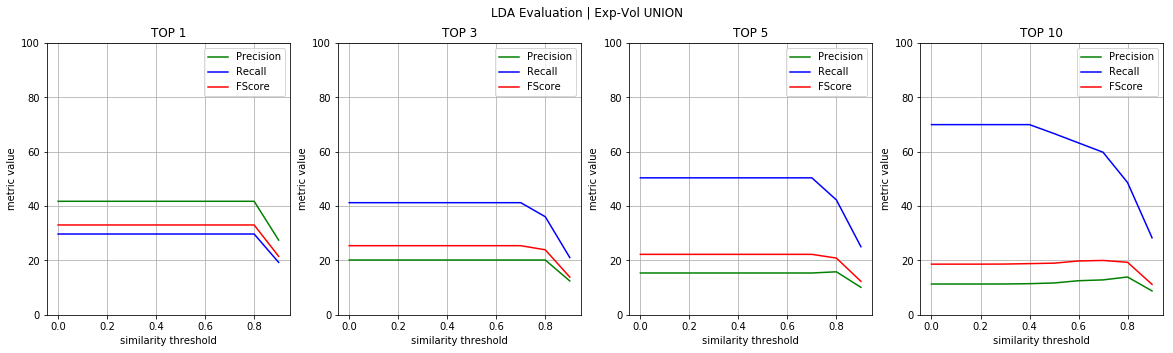

In [8]:
results = evaluator_1.get_evaluations_df()
evaluator_1.plot_evaluations_2(title='LDA Evaluation | Exp-Vol UNION', results=results)

# Analysis of False Positives

In [ ]:
TP, FP, FN, TN = 0,0,0,0

# Analysis of False Negatives